In [47]:
#Questions:
""" GERON
Note that since instances are picked randomly, some instances may be picked several times per epoch
while others may not be picked at all. If you want to be sure that the algorithm goes through every instance
at each epoch, another approach is to shuffle the training set, then go through it instance by instance, then
shuffle it again, and so on. However, this generally converges more slowly.

""";

# stratified train test split

#  For LogReg
# mix? sgd for a while, then gd? PRØV
# regularization is cool i guess? finding the lowest minima = overfitting? japp
# could add the svd madness as LR? prøv


#network
# more lr methods? kanskja Adam, usikker? prøv. også momentum gd
# more inits? xavier+kaiming
# husk drop out for NN!
# markov dropout? husk å dele på drop out sannsynligheten. SB ps sannsynlighets estimat som regularisering.
# batch normalization
#dropout drop different nodes forward and bacwards? 

In [48]:
#ToDo:
# make more lr and init methods
#mix? sgd for a while, then gd?
#sgd no shuffle
#regularization in optimization!
# could add the svd madness as LR?
#stratified?

In [49]:
#importing packages
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.linear_model import SGDClassifier
import scipy.linalg as scl

In [2027]:
def ReadData():
    #importing data set(s)
    filename = 'default of credit card clients.xls'
    nanDict = {} #this does nothing with this data set
    #read file
    df = pd.read_excel(filename,header=1,skiprows=0,index_col=0,na_values=nanDict) 
    #rename last column
    df.rename(index=str, columns={"default payment next month": "defaultPaymentNextMonth"}, inplace=True)
    #Replace nonsensical values in PAY_i columns with 0
    for i in [0,2,3,4,5,6]:
        col = 'PAY_{}'.format(i)
        df[col].replace(to_replace=-2, value = 0, inplace=True)
    #shuffle dataset by row
    df.sample(frac=1)
    
    # Define features and targets 
    X = df.loc[:, df.columns != 'defaultPaymentNextMonth'].values
    y = df.loc[:, df.columns == 'defaultPaymentNextMonth'].values
    
    # Categorical variables to one-hots, setting nonsensical values to 0
    onehotencoder1 = OneHotEncoder(categories='auto')
    onehotencoder2 = OneHotEncoder(categories='auto',drop='first')

    # sets number of elements in onehot vectors automatically from data.
    Xt= ColumnTransformer(
        [("one", onehotencoder1, [1]),("two", onehotencoder2, [2,3]),],
        remainder="passthrough"
    ).fit_transform(X)

    # Train-test split
    trainingShare = 0.5
    seed  = 1
    XTrain, XTest, yTrain, yTest=train_test_split(Xt, y, train_size=trainingShare, \
                                                  test_size = 1-trainingShare,
                                                 random_state=seed, stratify = y)
    
    #scale data, except one-hotted
    sc = StandardScaler()
    XTrain_fitting = XTrain[:,11:]
    XTest_fitting = XTest[:,11:]
    #removes mean, scales by std
    XTrain_scaler = sc.fit_transform(XTrain_fitting)
    XTest_scaler = sc.transform(XTest_fitting)
    #puts together the complete model matrix again
    XTrain_scaled=np.c_[XTrain[:,:11],XTrain_scaler]
    XTest_scaled = np.c_[XTest[:,:11],XTest_scaler]


    
    
    return XTrain_scaled,XTest_scaled,yTrain,yTest

In [51]:
def sigmoid(s):
    return 1./(1.+np.exp(-s))

In [52]:
def Gradient(X,theta,y):
    return (X.T@(sigmoid(X@theta)-y))

In [53]:
def CostFunction(X,theta,y):
    y_pred= sigmoid(X@theta)
    y_pred_neg = sigmoid(-X@theta)
    cost__ = -y*np.log(y_pred)-(1-y)*np.log(y_pred_neg)
    cost_ = np.sum(cost__,axis=0)
#     print(cost__)
    return cost_/len(y)

In [54]:
"""
Takes two arrays of equal length and calculates the "Accuracy score"
"""
def Accuracy(t,y):
    assert len(t)==len(y), "y and y_pred dimensions do not match ({},{}).".format(len(t),len(y))
    s = [1 if i else 0 for i in np.equal(t,y)]
    return np.sum(s)/len(t)

In [55]:
"""
this function is pretty much stolen from
https://stackoverflow.com/questions/38157972/how-to-implement-mini-batch-gradient-descent-in-python
users Ash and dsachar
"""
def BatchIterator(X,y,batch_size,shuffle=True):
    assert X.shape[0]==y.shape[0], "X and y dimensions do not match ({},{}).".format(X.shape[0],y.shape[0])
    if shuffle:
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
    for start_index in range(0,X.shape[0],batch_size):
        end_index = min(start_index+batch_size,X.shape[0])
        if shuffle:
            batch_indices = indices[start_index:end_index]
        else:
            batch_indices = slice(start_index,end_index)
        yield X[batch_indices],y[batch_indices]

In [56]:
def simulated_annealing(t):# simulated annealing?
        t0,t1 = 5,50
        return t0/(t+t1)

In [57]:
def ols_svd(X:np.ndarray)->np.ndarray:
    u, s, v = scl.svd(X)
    return np.dot(v.transpose(),np.dot(np.diag(s**-1),u.transpose()))

In [60]:
def SGD(XTrain,yTrain,XTest,yTest,gd_method='GD',lr_method='const',init_method='rand',tol=1e-4,
        max_iters=200,eta=0.00001,N_epochs=200,N_batches=100,Shuffle=True,seed=None):
   
    #INIT METHODS
    if seed != None:
        np.random.seed(seed)
    theta = np.random.randn(XTrain.shape[1],1) #if function is convex, start point wont matter, and this is fine
    
    #LR METHODS
    #     u,s,v = np.linalg.svd(XTrain_scaled.T@XTrain_scaled)
    #     eta = 2/np.max(s) # learning rate must be smaller than this in order to converge!  
    #evt svd igjen for max gamma

    ce_prev = 1e6
    ce=1e6+1
    
    #GD METHODS    
    if gd_method=='NR': #Newton-Raphson
        c=0
        theta=np.zeros((XTrain.shape[1],1))
        while abs(ce-ce_prev)>tol and c<max_iters:
            ce_prev=ce
            probs = sigmoid(XTrain@theta)
            W = np.zeros(yTrain.shape[0])
            for i in range(yTrain.shape[0]):
                W[i] = probs[i]*(1-probs[i])
            H = XTrain.T@np.diagflat(W)@XTrain
            Hinv=np.linalg.inv(H)          
            gradient = Gradient(XTrain,theta,yTrain)
            theta -= Hinv@gradient
            ce = CostFunction(XTrain,theta,yTrain) #used for convergence check
            c +=1
    if gd_method=='GD': #Gradient Descent
        c = 0
        while abs(ce-ce_prev)>tol and c<max_iters:
            ce_prev=ce
            gradient = Gradient(XTrain,theta,yTrain)
            theta -= eta*gradient*0.9999
            ce = CostFunction(XTrain,theta,yTrain) #used for convergence check
            c+=1

    if gd_method=='SGD': #Stochastic Gradient Descent
        for epoch in range(N_epochs):
            for i in range(XTrain.shape[0]):
                random_index = np.random.randint(XTrain.shape[0])
                xi = XTrain[random_index:random_index+1]
                yi = yTrain[random_index:random_index+1]
                gradient = Gradient(xi,theta,yi)
                eta=simulated_annealing(epoch*N_batches+i)
                theta -=eta*gradient

    if gd_method =='SGDmb': #Stochastic Gradient Descent with minibatches
        for epoch in range(N_epochs):
            for batch in BatchIterator(XTrain,yTrain,int(XTrain.shape[0]/N_batches)+1,shuffle=Shuffle):
                X_batch,y_batch = batch
                gradient = Gradient(X_batch,theta,y_batch)
                theta -= eta*gradient
            eta=simulated_annealing(epoch) #eller noe?

    if gd_method == 'skl': #scikit learn gradient descent
        sgd_clf = SGDClassifier(random_state=1,loss='log',tol=1e-5,max_iter=500,penalty='none',alpha=0.,eta0=eta,learning_rate='constant',fit_intercept=False)
        sgd_clf.fit(XTrain,yTrain.ravel());
        theta = sgd_clf.coef_[0,:].reshape(-1,1)

    #CALC AND OUTPUT ACCURACY
    y_pred_ = sigmoid(XTest@theta)
    y_out = sigmoid(XTest@theta)
    y_pred_[y_pred_>=0.5]=1
    y_pred_[y_pred_<0.5]=0

    forvirring = sklearn.metrics.confusion_matrix(yTest, y_pred_, labels=None, sample_weight=None)
    print(forvirring.T)
    strings = ["Accuracy baseline: ","Accuracy of {} method: ".format(gd_method)]
    print("{:26s}   {:5f}".format(strings[0],Accuracy(yTest,np.zeros((yTest.shape)))))
    print("{:26s}   {:5f}".format(strings[1],Accuracy(yTest,y_pred_)))
    print("---------------------------------------")
    return y_out

In [61]:
XTrain,XTest,yTrain,yTest = ReadData()
y_thing_self = SGD(XTrain,yTrain,XTest,yTest,gd_method='NR')
y_thing = SGD(XTrain,yTrain,XTest,yTest,gd_method='skl')

[[11235  2454]
 [  402   909]]
Accuracy baseline:           0.775800
Accuracy of NR method:       0.809600
---------------------------------------
[[11229  2511]
 [  408   852]]
Accuracy baseline:           0.775800
Accuracy of skl method:      0.805400
---------------------------------------


<Figure size 432x288 with 0 Axes>

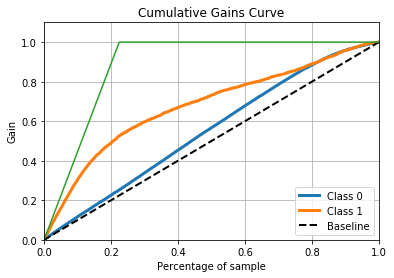

0.7295325023123027


<Figure size 432x288 with 0 Axes>

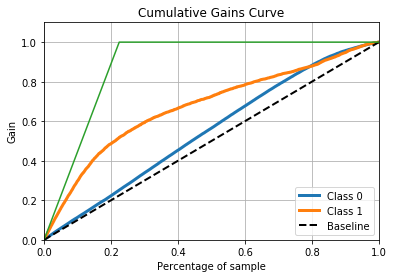

0.7250088545535862


In [65]:
defaults = sum(yTest == 1)
total = len(yTest)
defaultRate = defaults/total

def bestCurve(defaults, total, defaultRate):
    x = np.linspace(0, 1, total)
    
    y1 = np.linspace(0, 1, defaults)
    y2 = np.ones(total-defaults)
    y3 = np.concatenate([y1,y2])
    return x, y3




cumul = np.zeros(len(y_thing)+1)
y_two = np.zeros(len(y_thing))
for i in range(len(y_thing)):
    y_two[i] = 1-y_thing[i]
y_T = np.c_[y_two,y_thing]

y_two2 = np.zeros(len(y_thing_self))
for i in range(len(y_thing_self)):
    y_two2[i] = 1-y_thing_self[i]
y_T2 = np.c_[y_two2,y_thing_self]
#     if y_thing[i] == 1:
#         cumul[i+1] = cumul[i]+1
#     else:
#         cumul[i+1] = cumul[i]
# c = 0
# for i  in range(len(yTest)):
#     if yTest[i]==1:
#         c+=1
# print(c)

# c = 0
# for i  in range(len(yTest)):
#     if y_thing[i]==1:
#         c+=1
# print(c)
import scikitplot as skplt
# print(np.shape(yTest.ravel()),np.shape(y_thing))
y_t = y_thing.reshape(len(y_thing))
# print(np.shape(y_t))
import matplotlib.pyplot as plt

plt.figure()
skplt.metrics.plot_cumulative_gain(yTest.ravel(), y_T2)
x, best = bestCurve(defaults=defaults, total=total, defaultRate=defaultRate)  
# plt.figure()
plt.plot(x, best)    
plt.ylim(top=1.1)
plt.show()
print(sklearn.metrics.roc_auc_score(yTest, y_thing_self))
plt.figure()
skplt.metrics.plot_cumulative_gain(yTest.ravel(), y_T)

# plt.plot(cumul)



x, best = bestCurve(defaults=defaults, total=total, defaultRate=defaultRate)  
# plt.figure()
plt.plot(x, best)    
plt.ylim(top=1.1)
plt.show()

print(sklearn.metrics.roc_auc_score(yTest, y_thing))

In [ ]:
#Read data and define methods and initialization seeds to run over
XTrain,XTest,yTrain,yTest = ReadData()
methods = ['NR','GD','SGD','SGDmb','skl']
seeds = [77,9865,75,34,875]
seeds = [858,8]

In [ ]:
#run regressions
for seed in seeds:
    print("Seed is {}.".format(seed))
    for method in methods:
        SGD(XTrain,yTrain,XTest,yTest,gd_method=method,seed=seed)

In [ ]:
# conf matrix!

In [ ]:
 sklearn.metrics.confusion_matrix(y_true, y_pred, labels=None, sample_weight=None)

In [13]:
import sklearn

# NN

In [938]:
## start NN fun
XTrain,XTest,yTrain,yTest = ReadData()

In [939]:
layers = np.arange(1,5)
np.random.seed(8)
n_nodes_l = np.random.randint(10,100,size=len(layers)-1)

n_nodes_in = np.array([XTrain.shape[1]])
n_nodes_out = np.array([1])
n_nodes = np.c_[[n_nodes_in],[n_nodes_l],[n_nodes_out]]
n_nodes = n_nodes.reshape((n_nodes.shape[1],))

#create matrix to store a-values
a_matrix=[]
# initialize
a_matrix.append(XTrain)

#create random start weights
w_matrix = []
w_out = np.random.randn(n_nodes[-2],2)
#initial weights and biases
for i in range(len(layers)): #xavier, he,
    np.random.seed(6)
    w_matrix.append(np.random.randn(n_nodes[i],n_nodes[i+1]))
    a_matrix.append(np.zeros((XTrain.shape[0],n_nodes[i+1])))

#create random biases
b = np.random.randn(len(layers))

In [940]:
# FEED FORWARD
for l in range(len(layers)):#burde ikke trenge oppdelingen
    if l==len(layers)-1:
        z = a_matrix[l]@w_out
        a_matrix[l+1] = sigmoid(z)
    else:
        z = a_matrix[l]@w_matrix[l] + b[l]
        a_matrix[l+1] = sigmoid(z)

In [ ]:
class NN:
    def __init__(XTrain,yTrain,XTest,yTest):
        self.XTest = XTest
        self.yTest = yTest
        self.XTrain = XTrain
        self.yTrain = Train

In [941]:
#calculate error

# err = (-yTrain*np.log(a_matrix[len(layers)])-(1-yTrain)*np.log(1-a_matrix[len(layers)]))



def to_categorical_numpy(integer_vector):
    n_inputs = len(integer_vector)
    n_categories = np.max(integer_vector) + 1
    onehot_vector = np.zeros((n_inputs, n_categories))
    onehot_vector[range(n_inputs), integer_vector] = 1
    
    return onehot_vector

#Y_train_onehot, Y_test_onehot = to_categorical(Y_train), to_categorical(Y_test)
Y_train_onehot, Y_test_onehot = to_categorical_numpy(yTrain), to_categorical_numpy(yTest)


In [946]:
#backpropagating
probs=a_matrix[len(layers)]

for i in reversed(range(len(layers))):
    errout= probs-Y_train_onehot
    if  i==3:
        errhid=(errout@w_out.T)@a_matrix[i].T@(1-a_matrix[i])
    else:
        errhid = (errhid@w_matrix[i].T)@a_matrix[i].T@(1-a_matrix[i])

In [944]:
# #calculate gradients
out_w_grad = a_matrix[1].T@errout
print(np.shape(out_w_grad),np.shape(Y_train_onehot))
# jippi, ser riktig ut...

(77, 2) (15000, 2)


# trying classes below

In [998]:
class Node:
    def __init__(self,
                 weights,
                 bias
                ):
        self.weights = weights
        self.bias = bias
        
    def FeedForward(self,
                    in_matrix
                   ):
        output=[]
        for row in range(in_matrix.shape[0]):
            y_pred = in_matrix[row]@self.weights+self.bias
            output.append(sigmoid(y_pred))
        return output
    
weights=np.random.randn(XTrain.shape[1])
print(weights)
bias = np.random.randn(1)
x=XTrain
noddy = Node(w_,bias)
print(noddy.FeedForward(x)[0])


[ 1.07368134 -0.37550472  0.39636757 -0.47144628  2.33660781  1.50278553
 -0.59545972  0.52834106  0.9398248   0.42628539 -0.75815703 -0.16236698
  0.72680996  0.44408297 -0.85682264  0.44692842 -1.01464799 -2.1323234
  0.17386307  0.95120126  0.44189739  1.46901739  1.74951635  0.35353062
 -0.64333729 -0.04723705 -1.44903979 -0.03618977 -0.09084699  0.17629034
  1.09462041]
[0.86477354]


In [1006]:
class Layer:
    def __init__(self,
                 weights,
                 bias,
                 nodes
                ):
        self.weights = weights
        self.bias=bias
        self.nodes = nodes
        
        
        self.nods = []
        for i in range(nodes):
            self.nods.append(Node(weights,bias))
#         lay = {nodes : Node(weights=weights,bias=bias) for node in range(nodes)}
#         print(i for i in np.arange(nodes))
#         print()
#         print(lay.keys())
#         print(lay)
#         for key in lay.keys():
#             print(key)
#         print(lay[12])
# print(np.shape(weights))
lugg = Layer(weights,bias,12)
# print(lugg.weights)
print(lugg.nods[0])
# 

In [679]:

class Network:
    def __init__(self):
        hidden_layer=np.zeros(4)
        next_layer=np.zeros(2)
        weights=np.random.randn(XTrain.shape[1])
        bias = np.random.randn(1) 
        h=[]
        o=[]
        for node in range(len(hidden_layer)):
            self.node = Node(weights,bias)
#             h.append(Node(weights,bias))
#         for node in range(len(next_layer)):
#             o.append(Node(weights,bias))
            #         self.in = Node(Weights,bias)
#         self.out = Node(weights,bias)
        print(self.node)
#     def FeedForward(self, x):

#         out_h1 = self.h1.FeedForward(x)
#         out_h2 = self.h2.FeedForward(x)

#         # The inputs for o1 are the outputs from h1 and h2
#         out_o1 = self.o1.FeedForward(np.array([out_h1, out_h2]))

#         return out_o1

network = Network()
x = XTrain
# print(network.FeedForward(x)) # 0.7216325609518421

In [697]:
def z_l(W,a,b):
    return W@a.T#+b

In [707]:
w1 = np.random.randn((31,10))
b=np.random.randn(1)
z = np.zeros(XTrain.shape[0])

z = w1@XTrain.T+b
a = sigmoid(z)



TypeError: 'tuple' object cannot be interpreted as an integer

In [1052]:
class Network:
    def __init__(
            self,
            XTrain,
            yTrain,
            XTest,
            yTest,
            n_layers,
            n_neurons, #per layer
            activations, #per layer
            batch_size,
            n_categories = 2,
            epochs = 10,
            eta=0.1,
            lambda_ = 0.0
        ):
        her=1
#         self.XTrain = XTrain
#         self.yTrain = yTrain
#         self.XTest  = XTest
#         self.yTest  = yTest

#DEFINERE DISSE UTENFOR?
#     def sigmoid(s): #definere forskjelige slike her under activations
#         return 1./(1.+np.exp(-s))
    
    def ForwardPropagation(
            self,
            XTrain,
            yTrain,
            weights,
            bias,
            activation = 'sigmoid'
        ):
        z = weights@XTrain.T+bias #kanskje? slang på T litt tilfeldig.
        a = sigmoid(z)
        return a
    
#     def CostFunction(
    
#         ):
#         def CostFunction(X,theta,y):
#     y_pred= sigmoid(X@theta)
#     y_pred_neg = sigmoid(-X@theta)
#     cost__ = -y*np.log(y_pred)-(1-y)*np.log(y_pred_neg)
#     cost_ = np.sum(cost__,axis=0)
# #     print(cost__)
#     return cost_/len(y)

In [1053]:
net = Network(XTrain,yTrain,XTest,yTest,len(layers),layers,'sigmoid',len(XTrain))

In [1054]:
forw = net.ForwardPropagation(XTrain,yTrain,weights,bias)

In [1055]:
print(forw)

[0.00153019 0.96626006 0.99996153 ... 0.06279218 0.5956789  0.14297028]


In [1671]:
#simplest version first i guess

class simple:
    def __init__(
            self,
            XTrain,
            yTrain,
            XTest,
            yTest,
            weights,
            bias,
            n_layers
        ):
        self.XTrain = XTrain
        self.yTrain = yTrain
        self.XTest  = XTest
        self.yTest  = yTest

        a = []
        self.a = a
        self.a.append(XTrain)
        batch_size=len(XTrain)
        z = []
        self.z = z

    def run(self):
        batch_size = len(XTrain)
        a = []
        self.a = a
        self.a.append(XTrain)
        batch_size=len(XTrain)
        z = []
        self.z = z
        for j in range(1000):
#             print(j)

    #         forward
            for i in range(n_layers):
                test = self.a[i]@weights[i]+bias[i]
                self.z.append(test)
                testa = sigmoid(test)
                self.a.append(testa)
                
            exp_term = np.exp(a[n_layers])
            probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)

#             error = CostFunction(XTrain,weights[0],yTrain)
    #         backwards
    #         for i in reversed(range(n_layers+1)):
            for i in reversed(range(n_layers)):
                if i==n_layers-1:
#                     dz = self.a[i]-yTrain #error output
                    dz = probabilities - self.yTrain
                else:
#                     print(np.shape(dz),np.shape(weights[i+1]),np.shape(self.z[i]*(1-self.z[i])))
    #                 dz = dz@weights[i].T*self.z[i-1]*(1-self.z[i-1]) #error hidden
                    dz = dz@weights[i+1]*self.z[i]*(1-self.z[i]) #error hidden
#                 print(np.shape(dz),np.shape(a[i]))
                dW = (1./batch_size)*dz.T@self.a[i] #weights gradient
                weights[i] -= 0.01*dW.T
#                 print(np.shape(dW))
#                 print("-------")
#                 print(np.shape(dz))
                db = (1./batch_size)*np.sum(dz.T,axis=1,keepdims=True)#bias gradient
#                 print(np.shape(db))
                bias[i] -= 0.01*np.mean(db) #GIRDETTE MENING?
#                 print(db)
#                 bias[i] -= 0.01*db.T
#             weights = weights - 0.01*dW
            a = []
            self.a = a
            self.a.append(XTrain)
            batch_size=len(XTrain)
            z = []
            self.z = z
        for i in range(n_layers):
                test = self.a[i]@weights[i]+bias[i]
                self.z.append(test)
                testa = sigmoid(test)
                self.a.append(testa)
                
        exp_term = np.exp(a[n_layers])
        probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
        preds = np.zeros(XTrain.shape[0])
        for i in range(probabilities.shape[0]):
            for j in range(2):
                if probabilities[i][j] >=0.5:
                    preds[i] = 1
                else:
                    preds[i] = 0
                
#         print(np.shape(probabilities),np.shape(yTrain))
#         print(yTrain)
#         print(np.shape(Y_train_onehot))
#         pred = np.zeros(XTrain.shape[0])
#         for i in range(batch_size):
#             if probabilities[i][1]>probabilities[i][0]:
#                 pred[i] = 1
#                 error = CostFunction(XTrain,weights[0],yTrain)
        print(Accuracy(preds,yTrain.reshape(yTrain.shape[0])))
        print(Accuracy(np.zeros(15000),yTrain.reshape(yTrain.shape[0])))

In [2304]:
weights_i=np.random.randn(XTrain.shape[1],2)
# print(weights)
bias_i = np.random.randn(1)
weights_o=np.random.randn(2,2)
# print(weights)
bias_o = np.random.randn(1)
# print(bias)
n_layers=2
weights = []
weights.append(weights_i)
weights.append(weights_o)
bias = []
bias.append(bias_i)
bias.append(bias_o)

def to_categorical_numpy(integer_vector):
    n_inputs = len(integer_vector)
    n_categories = np.max(integer_vector) + 1
    onehot_vector = np.zeros((n_inputs, n_categories))
    onehot_vector[range(n_inputs), integer_vector] = 1
    
    return onehot_vector

#Y_train_onehot, Y_test_onehot = to_categorical(Y_train), to_categorical(Y_test)
Y_train_onehot, Y_test_onehot = to_categorical_numpy(yTrain), to_categorical_numpy(yTest)


XTrainz=XTrain[:1500,11:]
# print(XTrainz)
# print(np.shape(Y_train_onehot))
simp = simple(XTrainz,Y_train_onehot,XTest,yTest,weights,bias,n_layers)
# simp = simple(XTrain,yTrain,XTest,yTest,weights,bias,n_layers)

# simp.forw(XTrain)
# print(np.shape(weights[0]))
simp.run()
# print(np.shape(weights[1]),"h",np.shape(weights[0]))
# print(bias)

/home/janfki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: overflow encountered in multiply


0.7788
0.7788


In [1587]:
#finner en dz, dw og db, så trenger alle disse å endre på. z = matrix(batch_size,1)?

In [1712]:
weights_i=np.random.randn(XTrain.shape[1],2)
# print(weights)
bias_i = np.random.randn(1)
weights_o=np.random.randn(2,2)
# print(weights)
bias_o = np.random.randn(1)
# print(bias)
n_layers=2
weights = []
weights.append(weights_i)
weights.append(weights_o)
bias = []
bias.append(bias_i)
bias.append(bias_o)

In [1713]:
def FF(X,w,b):
    z = []
    a = []
    a.append(X)
    for i in range(n_layers):
        z.append(a[i]@w[i]+b[i])
        a.append(sigmoid(z[i]))
    exp_term = np.exp(z[n_layers-1])
    probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
    return a,probabilities

In [1744]:
def BP(X,Y):
    a, probabilities = FF(XTrain,weights,bias)
    err = probabilities - Y
    for i in reversed(range(n_layers)):
        print(i,np.shape(err),np.shape(weights[i]))
        err_hidd  = err@weights[i]*a[i]*(1-a[i])
        print(np.shape(err_hid),np.shape(a[i-1]))
        print("----")
#         err = err_hid

In [1745]:
for i in range(10):
    BP(XTrain,Y_train_onehot)

1 (15000, 2) (2, 2)
(15000, 77) (15000, 31)
----
0 (15000, 2) (31, 2)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 31 is different from 2)

In [2433]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets


# ensure the same random numbers appear every time
np.random.seed(0)

# display images in notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,12)


# download MNIST dataset
digits = datasets.load_digits()

# define inputs and labels
inputs = digits.images
labels = digits.target

print(np.shape(inputs))
print("inputs = (n_inputs, pixel_width, pixel_height) = " + str(inputs.shape))
print("labels = (n_inputs) = " + str(labels.shape))


# flatten the image
# the value -1 means dimension is inferred from the remaining dimensions: 8x8 = 64
n_inputs = len(inputs)
inputs = inputs.reshape(n_inputs, -1)
from sklearn.model_selection import train_test_split

# one-liner from scikit-learn library
train_size = 0.8
test_size = 1 - train_size
X_train, X_test, Y_train, Y_test = train_test_split(inputs, labels, train_size=train_size,
                                                    test_size=test_size)


# building our neural network

n_inputs, n_features = X_train.shape
n_hidden_neurons = 50
n_categories = 10

# we make the weights normally distributed using numpy.random.randn

# weights and bias in the hidden layer
hidden_weights = np.random.randn(n_features, n_hidden_neurons)
hidden_bias = np.zeros(n_hidden_neurons) + 0.01

# weights and bias in the output layer
output_weights = np.random.randn(n_hidden_neurons, n_categories)
output_bias = np.zeros(n_categories) + 0.01
def to_categorical_numpy(integer_vector):
    n_inputs = len(integer_vector)
    n_categories = np.max(integer_vector) + 1
    onehot_vector = np.zeros((n_inputs, n_categories))
    onehot_vector[range(n_inputs), integer_vector] = 1
    
    return onehot_vector
from keras.utils import to_categorical

Y_train_onehot, Y_test_onehot = to_categorical(Y_train), to_categorical(Y_test)



(1797, 8, 8)
inputs = (n_inputs, pixel_width, pixel_height) = (1797, 8, 8)
labels = (n_inputs) = (1797,)


# PROGRAM USING FUNCTIONS!

In [2605]:
nn_architecture = [
    {"input_dim": 31, "output_dim": 4, "activation": "relu"},
    {"input_dim": 4, "output_dim": 6, "activation": "relu"},
    {"input_dim": 6, "output_dim": 6, "activation": "relu"},
    {"input_dim": 6, "output_dim": 4, "activation": "relu"},
    {"input_dim": 4, "output_dim": 1, "activation": "sigmoid"},

]

In [2606]:
def init_layers(nn_architecture, seed = 99):
    np.random.seed(seed)
    number_of_layers = len(nn_architecture)
    params_values = {}

    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        params_values['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * 0.1
        
    return params_values

In [2607]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;

In [2608]:
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    if activation is "relu":
        activation_func = relu
    elif activation is "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception('Non-supported activation function')
        
    return activation_func(Z_curr), Z_curr

In [2609]:
def full_forward_propagation(X, params_values, nn_architecture):
    memory = {}
    A_curr = X
    
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        A_prev = A_curr
        
        activ_function_curr = layer["activation"]
        W_curr = params_values["W" + str(layer_idx)]
        b_curr = params_values["b" + str(layer_idx)]
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)
        
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    return A_curr, memory

In [2547]:
def get_cost_value(Y_hat, Y):
    m = Y_hat.shape[1]
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    return np.squeeze(cost)
    
def convert_prob_into_class(probs):
                    probs_ = np.copy(probs)
                    probs_[probs_ > 0.5] = 1
                    probs_[probs_ <= 0.5] = 0
                    return probs_
                
def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()

In [2610]:
def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    m = A_prev.shape[1]
    
    if activation is "relu":
        backward_activation_func = relu_backward
    elif activation is "sigmoid":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Non-supported activation function')
    
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

In [2549]:
def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
    m = Y.shape[1]
    Y = Y.reshape(Y_hat.shape)
   
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        layer_idx_curr = layer_idx_prev + 1
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

In [2601]:
def update(params_values, grads_values, nn_architecture, learning_rate):
    for layer_idx, layer in enumerate(nn_architecture,1):
        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

    return params_values;

In [2611]:
def train(X, Y, nn_architecture, epochs, learning_rate):
    params_values = init_layers(nn_architecture, 2)
    cost_history = []
    accuracy_history = []
    y_things=[]
    for i in range(epochs):
        Y_hat, cashe = full_forward_propagation(X, params_values, nn_architecture)
        cost = get_cost_value(Y_hat, Y)
        cost_history.append(cost)
        accuracy = get_accuracy_value(Y_hat, Y)
        accuracy_history.append(accuracy)
        y_things.append(Y_hat)
        grads_values = full_backward_propagation(Y_hat, Y, cashe, params_values, nn_architecture)
        params_values = update(params_values, grads_values, nn_architecture, learning_rate)
    return params_values, cost_history, accuracy_history,y_things

In [2749]:
XTrain,XTest,yTrain,yTest=ReadData()
Y_train_onehot, Y_test_onehot = to_categorical(yTrain), to_categorical(yTest)

nn_architecture = [
    {"input_dim": 31, "output_dim": 100, "activation": "relu"},
    {"input_dim": 100, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 1, "activation": "sigmoid"},
]

para,cos,acc,y = train(XTrain.T,yTrain.T, nn_architecture,1000,1.e-01)
Y_test_hat,_ = full_forward_propagation(XTest.T,para,nn_architecture)
# acc_test = get_accuracy_value(predd.T,yTest.T)
# print("Test set accuracy: ",acc_test)
# zeroses = np.zeros((1,15000))
# acc_test = get_accuracy_value(yTest.T,zeroses.T)
# print("Zero set accuracy: ",acc_test)

# Accuracy achieved on the test set
acc_test = get_accuracy_value(Y_test_hat, np.transpose(yTest.reshape((yTest.shape[0], 1))))
print("Test set accuracy: {:.2f} ".format(acc_test))
zerot = np.zeros(yTest.shape[0])
acc_test = get_accuracy_value(np.transpose(yTest.reshape((yTest.shape[0], 1))), np.transpose(zerot.reshape((zerot.shape[0], 1))))
print("Zero set accuracy: {:.2f} ".format(acc_test))


Test set accuracy: 0.82 
Zero set accuracy: 0.78 


In [2733]:
# print(yTest)
# print(Y_test_hat)
print(np.mean(Y_test_hat))
def convert_prob_into_class2(probs):
                    probs_ = np.copy(probs)
                    p=0.221199
                    probs_[probs_ > p] = 1
                    probs_[probs_ <= p] = 0
                    return probs_
Y_test_binaried = convert_prob_into_class2(Y_test_hat)
Y_test_binaried = Y_test_binaried.reshape(Y_test_binaried.shape[1])
yTest = yTest.reshape(yTest.shape[0])
# print(np.shape(Y_test_binaried),np.shape(yTest))
forvirring = sklearn.metrics.confusion_matrix(yTest, Y_test_binaried, labels=None, sample_weight=None)
print(forvirring)
print(np.shape(Y_test_binaried),np.shape(yTest))
# print(get_accuracy_value2(yTest.T,Y_test_hat.T))
print(Accuracy(yTest,Y_test_binaried))
print(Accuracy(yTest,zerot))

0.2211996523360696
[[6644 5038]
 [1809 1509]]
(15000,) (15000,)
0.5435333333333333
0.7788


In [2653]:


NN_ARCHITECTURE = [
    {"input_dim": 2, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 1, "activation": "sigmoid"},
]



# number of samples in the data set
N_SAMPLES = 1000
# ratio between training and test sets
TEST_SIZE = 0.1
from sklearn.datasets import make_moons


X, y = make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)



# Training
params_values = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, 10000, 0.01)[0]
# Prediction
Y_test_hat, _ = full_forward_propagation(np.transpose(X_test), params_values, NN_ARCHITECTURE)
# acc_test = get_accuracy_value(params_values,y_test.T)

# Accuracy achieved on the test set
acc_test = get_accuracy_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))
print("Test set accuracy: {:.2f} ".format(acc_test))
zerot = np.zeros(y_test.shape[0])
acc_test = get_accuracy_value(np.transpose(y_test.reshape((y_test.shape[0], 1))), np.transpose(zerot.reshape((zerot.shape[0], 1))))
print("Zero set accuracy: {:.2f} ".format(acc_test))

Test set accuracy: 0.98 
Zero set accuracy: 0.54 


In [2647]:
print(type(Y_test_hat),np.shape(Y_test_hat))
print(type(y_test),np.shape(y_test))
print(np.max(Y_test_hat))

<class 'numpy.ndarray'> (1, 100)
<class 'numpy.ndarray'> (100,)
0.9998952362783228


In [2658]:


NN_ARCHITECTURE = [
    {"input_dim": 2, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 1, "activation": "sigmoid"},
]



# number of samples in the data set
N_SAMPLES = 1000
# ratio between training and test sets
TEST_SIZE = 0.1
from sklearn.datasets import make_circles


X, y = make_circles(n_samples = N_SAMPLES, noise=0.2, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)
print(np.shape(y_test))

# Training
params_values = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, 10000, 0.1)[0]
# Prediction
Y_test_hat, _ = full_forward_propagation(np.transpose(X_test), params_values, NN_ARCHITECTURE)
# acc_test = get_accuracy_value(params_values,y_test.T)

# Accuracy achieved on the test set
acc_test = get_accuracy_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))
print("Test set accuracy: {:.2f} ".format(acc_test))
zerot = np.ones(y_test.shape[0])
acc_test = get_accuracy_value(np.transpose(y_test.reshape((y_test.shape[0], 1))), np.transpose(zerot.reshape((zerot.shape[0], 1))))
print("Zero set accuracy: {:.2f} ".format(acc_test))

(100,)
Test set accuracy: 0.68 
Zero set accuracy: 0.46 


<Figure size 432x288 with 0 Axes>

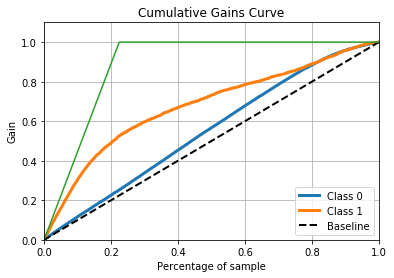

0.7295325023123027


<Figure size 432x288 with 0 Axes>

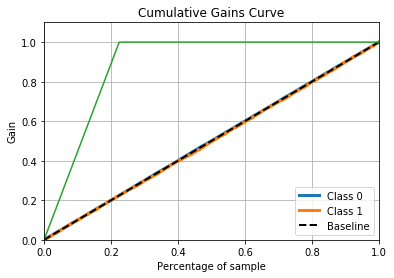

0.5


In [1791]:
defaults = sum(yTest == 1)
total = len(yTest)
defaultRate = defaults/total

def bestCurve(defaults, total, defaultRate):
    x = np.linspace(0, 1, total)
    
    y1 = np.linspace(0, 1, defaults)
    y2 = np.ones(total-defaults)
    y3 = np.concatenate([y1,y2])
    return x, y3




cumul = np.zeros(len(y_thing)+1)
y_two = np.zeros(len(y_thing))
for i in range(len(y_thing)):
    y_two[i] = 1-y_thing[i]
y_T = np.c_[y_two,y_thing]

y_two2 = np.zeros(len(y_thing_self))
for i in range(len(y_thing_self)):
    y_two2[i] = 1-y_thing_self[i]
y_T2 = np.c_[y_two2,y_thing_self]
#     if y_thing[i] == 1:
#         cumul[i+1] = cumul[i]+1
#     else:
#         cumul[i+1] = cumul[i]
# c = 0
# for i  in range(len(yTest)):
#     if yTest[i]==1:
#         c+=1
# print(c)

# c = 0
# for i  in range(len(yTest)):
#     if y_thing[i]==1:
#         c+=1
# print(c)
import scikitplot as skplt
# print(np.shape(yTest.ravel()),np.shape(y_thing))
y_t = y_thing.reshape(len(y_thing))
# print(np.shape(y_t))
import matplotlib.pyplot as plt

plt.figure()
skplt.metrics.plot_cumulative_gain(yTest.ravel(), y_T2)
x, best = bestCurve(defaults=defaults, total=total, defaultRate=defaultRate)  
# plt.figure()
plt.plot(x, best)    
plt.ylim(top=1.1)
plt.show()
print(sklearn.metrics.roc_auc_score(yTest, y_thing_self))
plt.figure()
skplt.metrics.plot_cumulative_gain(yTest.ravel(), y_T)

# plt.plot(cumul)



x, best = bestCurve(defaults=defaults, total=total, defaultRate=defaultRate)  
# plt.figure()
plt.plot(x, best)    
plt.ylim(top=1.1)
plt.show()

print(sklearn.metrics.roc_auc_score(yTest, y_thing))

# MORTEN TENSOR FLOW

In [1824]:
import tensorflow as tf
class NeuralNetworkTensorflow:
    def __init__(
            self,
            X_train,
            Y_train,
            X_test,
            Y_test,
            n_neurons_layer1=100,
            n_neurons_layer2=50,
            n_categories=2,
            epochs=10,
            batch_size=100,
            eta=0.1,
            lmbd=0.0):
        
        # keep track of number of steps
        self.global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
        
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test
        
        self.n_inputs = X_train.shape[0]
        self.n_features = X_train.shape[1]
        self.n_neurons_layer1 = n_neurons_layer1
        self.n_neurons_layer2 = n_neurons_layer2
        self.n_categories = n_categories
        
        self.epochs = epochs
        self.batch_size = batch_size
        self.iterations = self.n_inputs // self.batch_size
        self.eta = eta
        self.lmbd = lmbd
        
        # build network piece by piece
        # name scopes (with) are used to enforce creation of new variables
        # https://www.tensorflow.org/guide/variables
        self.create_placeholders()
        self.create_DNN()
        self.create_loss()
        self.create_optimiser()
        self.create_accuracy()
    
    def create_placeholders(self):
        # placeholders are fine here, but "Datasets" are the preferred method
        # of streaming data into a model
        with tf.compat.v1.name_scope('data'):
#             tf.compat.v1.placeholder
            self.X = tf.compat.v1.placeholder(tf.float32, shape=(None, self.n_features), name='X_data')
            self.Y = tf.compat.v1.placeholder(tf.float32, shape=(None, self.n_categories), name='Y_data')
#             self.X = tf.compat.v1.placeholder(tf.float32, shape=(None, self.n_features), name='X_data')
#             self.Y = tf.compat.v1.placeholder(tf.float32, shape=(None, self.n_categories), name='Y_data')
    
    def create_DNN(self):
        with tf.compat.v1.name_scope('DNN'):
            # the weights are stored to calculate regularization loss later
            
            # Fully connected layer 1
            self.W_fc1 = self.weight_variable([self.n_features, self.n_neurons_layer1], name='fc1', dtype=tf.float32)
            b_fc1 = self.bias_variable([self.n_neurons_layer1], name='fc1', dtype=tf.float32)
            a_fc1 = tf.nn.sigmoid(tf.matmul(self.X, self.W_fc1) + b_fc1)
            
            # Fully connected layer 2
            self.W_fc2 = self.weight_variable([self.n_neurons_layer1, self.n_neurons_layer2], name='fc2', dtype=tf.float32)
            b_fc2 = self.bias_variable([self.n_neurons_layer2], name='fc2', dtype=tf.float32)
            a_fc2 = tf.nn.sigmoid(tf.matmul(a_fc1, self.W_fc2) + b_fc2)
            
            # Output layer
            self.W_out = self.weight_variable([self.n_neurons_layer2, self.n_categories], name='out', dtype=tf.float32)
            b_out = self.bias_variable([self.n_categories], name='out', dtype=tf.float32)
            self.z_out = tf.matmul(a_fc2, self.W_out) + b_out
    
    def create_loss(self):
        with tf.compat.v1.name_scope('loss'):
            softmax_loss = tf.reduce_mean(input_tensor=tf.nn.softmax_cross_entropy_with_logits(labels=self.Y, logits=self.z_out))
            
            regularizer_loss_fc1 = tf.nn.l2_loss(self.W_fc1)
            regularizer_loss_fc2 = tf.nn.l2_loss(self.W_fc2)
            regularizer_loss_out = tf.nn.l2_loss(self.W_out)
            regularizer_loss = self.lmbd*(regularizer_loss_fc1 + regularizer_loss_fc2 + regularizer_loss_out)
            
            self.loss = softmax_loss + regularizer_loss

    def create_accuracy(self):
        with tf.compat.v1.name_scope('accuracy'):
            probabilities = tf.nn.softmax(self.z_out)
            predictions = tf.argmax(input=probabilities, axis=1)
            labels = tf.argmax(input=self.Y, axis=1)
            
            correct_predictions = tf.equal(predictions, labels)
            correct_predictions = tf.cast(correct_predictions, tf.float32)
            self.accuracy = tf.reduce_mean(input_tensor=correct_predictions)
    
    def create_optimiser(self):
        with tf.compat.v1.name_scope('optimizer'):
            self.optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=self.eta).minimize(self.loss, global_step=self.global_step)
            
    def weight_variable(self, shape, name='', dtype=tf.float32):
        initial = tf.random.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial, name=name, dtype=dtype)
    
    def bias_variable(self, shape, name='', dtype=tf.float32):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial, name=name, dtype=dtype)
    
    def fit(self):
        data_indices = np.arange(self.n_inputs)

        with tf.compat.v1.Session() as sess:
            sess.run(tf.compat.v1.global_variables_initializer())
            for i in range(self.epochs):
                for j in range(self.iterations):
                    chosen_datapoints = np.random.choice(data_indices, size=self.batch_size, replace=False)
                    batch_X, batch_Y = self.X_train[chosen_datapoints], self.Y_train[chosen_datapoints]
                    sess.run([DNN.loss, DNN.optimizer],
                        feed_dict={DNN.X: batch_X,
                                   DNN.Y: batch_Y})
                    accuracy = sess.run(DNN.accuracy,
                        feed_dict={DNN.X: batch_X,
                                   DNN.Y: batch_Y=})
                    step = sess.run(DNN.global_step)
    
            self.train_loss, self.train_accuracy = sess.run([DNN.loss, DNN.accuracy],
                feed_dict={DNN.X: self.X_train,
                           DNN.Y: self.Y_train})
        
            self.test_loss, self.test_accuracy = sess.run([DNN.loss, DNN.accuracy],
                feed_dict={DNN.X: self.X_test,
                           DNN.Y: self.Y_test})

In [2743]:
epochs = 100
batch_size = 100
n_neurons_layer1 = 100
n_neurons_layer2 = 50
n_categories = 2
eta_vals = np.logspace(-5, 1, 7)
lmbd_vals = np.logspace(-4, 1, 6)
lmbd_vals = np.hstack((0,lmbd_vals))
print(eta_vals)

[1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01]


In [2741]:
DNN_tf = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

# XTrain,yTrain,XTest,yTest = ReadData()
# Y_train_onehot, Y_test_onehot = to_categorical(yTrain), to_categorical(yTest)
# Y_train_onehot, Y_test_onehot

for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        DNN = NeuralNetworkTensorflow(XTrain, Y_train_onehot, XTest, Y_test_onehot,
                                      n_neurons_layer1, n_neurons_layer2, n_categories,
                                      epochs=epochs, batch_size=batch_size, eta=eta, lmbd=lmbd)
        DNN.fit()
        
        DNN_tf[i][j] = DNN
        
        print("Learning rate = ", eta)
        print("Lambda = ", lmbd)
        print("Test accuracy: %.3f" % DNN.test_accuracy)
        print()

Learning rate =  1e-05
Lambda =  0.0
Test accuracy: 0.779

Learning rate =  1e-05
Lambda =  0.0001
Test accuracy: 0.779

Learning rate =  1e-05
Lambda =  0.001
Test accuracy: 0.779

Learning rate =  1e-05
Lambda =  0.01
Test accuracy: 0.779

Learning rate =  1e-05
Lambda =  0.1
Test accuracy: 0.779

Learning rate =  1e-05
Lambda =  1.0
Test accuracy: 0.779

Learning rate =  1e-05
Lambda =  10.0
Test accuracy: 0.779

Learning rate =  0.0001
Lambda =  0.0
Test accuracy: 0.779

Learning rate =  0.0001
Lambda =  0.0001
Test accuracy: 0.779

Learning rate =  0.0001
Lambda =  0.001
Test accuracy: 0.779

Learning rate =  0.0001
Lambda =  0.01
Test accuracy: 0.779

Learning rate =  0.0001
Lambda =  0.1
Test accuracy: 0.779

Learning rate =  0.0001
Lambda =  1.0
Test accuracy: 0.779

Learning rate =  0.0001
Lambda =  10.0
Test accuracy: 0.779

Learning rate =  0.001
Lambda =  0.0
Test accuracy: 0.779

Learning rate =  0.001
Lambda =  0.0001
Test accuracy: 0.779

Learning rate =  0.001
Lambda = 

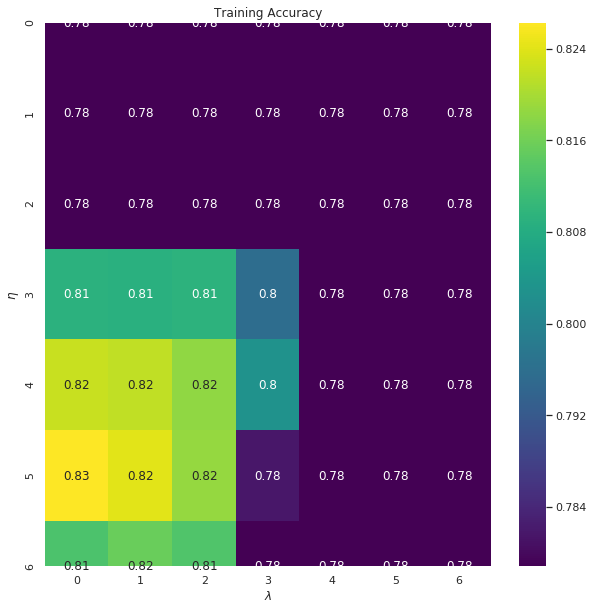

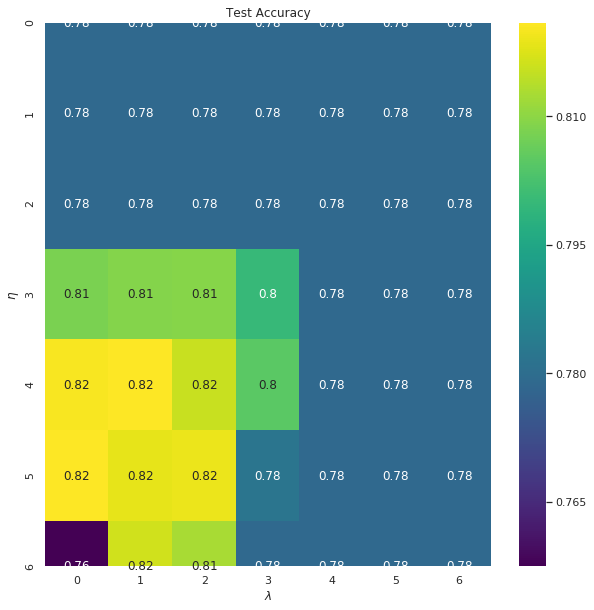

In [2742]:
# optional
# visual representation of grid search
# uses seaborn heatmap, could probably do this in matplotlib
import seaborn as sns

sns.set()

train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))

for i in range(len(eta_vals)):
    for j in range(len(lmbd_vals)):
        DNN = DNN_tf[i][j]

        train_accuracy[i][j] = DNN.train_accuracy
        test_accuracy[i][j] = DNN.test_accuracy

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

In [2372]:
XTrain,XTest,yTrain,yTest = ReadData()
yTrain=np.squeeze(yTrain)
from sklearn.metrics import accuracy_score
def to_categorical_numpy(integer_vector):
    n_inputs = len(integer_vector)
    n_categories = np.max(integer_vector) + 1
    onehot_vector = np.zeros((n_inputs, n_categories))
    onehot_vector[range(n_inputs), integer_vector] = 1
    
    return onehot_vector
from keras.utils import to_categorical

#Y_train_onehot, Y_test_onehot = to_categorical(Y_train), to_categorical(Y_test)
# Y_train_onehot, Y_test_onehot = to_categorical_numpy(yTrain), to_categorical_numpy(yTest)
Y_train_onehot, Y_test_onehot = to_categorical(yTrain), to_categorical(yTest)
# print(np.min(Y_train_onehot))
print(np.shape(XTrain),np.shape(yTrain),np.shape(Y_train_onehot))

# def sigmoid(x):
#     return np.where(x >= 0, 
#                     1 / (1 + np.exp(-x)), 
#                     np.exp(x) / (1 + np.exp(x)))
def sigmoid(x):
    return np.where(x >= 1e-10,
                    1 / (1 + np.exp(-x)), 
                    0)

(15000, 31) (15000,) (15000, 2)


In [2429]:
class NeuralNetwork:
    def __init__(
            self,
            X_data,
            Y_data,
            n_hidden_neurons=50,
            n_categories=2,
            epochs=10,
            batch_size=100,
            eta=0.001,
            lmbd=0.0):

        self.X_data_full = X_data
        self.Y_data_full = Y_data
        self.n_inputs = X_data.shape[0]
        self.n_features = X_data.shape[1]
        self.n_hidden_neurons = n_hidden_neurons
        self.n_categories = n_categories

        self.epochs = epochs
        self.batch_size = batch_size
        self.iterations = self.n_inputs // self.batch_size
        print(self.iterations)
        self.eta = eta
        self.lmbd = lmbd

        self.create_biases_and_weights()
#         print(self.hidden_weights)
#         print(self.output_weights)

    def create_biases_and_weights(self):
        self.hidden_weights = np.random.randn(self.n_features, self.n_hidden_neurons)
        self.hidden_bias = np.zeros(self.n_hidden_neurons) + 0.01

        self.output_weights = np.random.randn(self.n_hidden_neurons, self.n_categories)
        self.output_bias = np.zeros(self.n_categories) + 0.01

    def feed_forward(self):
        # feed-forward for training
        self.z_h = np.matmul(self.X_data, self.hidden_weights) + self.hidden_bias
#         print("----------ZH--------------")
#         print(self.z_h)
#         print("-----------------AH----------------------------")
        self.a_h = sigmoid(self.z_h)
#         print(self.a_h)
        self.z_o = np.matmul(self.a_h, self.output_weights) + self.output_bias
#         print(self.z_o)
        exp_term = np.exp(self.z_o)
#         print(exp_term)
        self.probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
#         print(np.sum(exp_term, axis=1, keepdims=True))

    def feed_forward_out(self, X):
        # feed-forward for output
        z_h = np.matmul(X, self.hidden_weights) + self.hidden_bias
        a_h = sigmoid(z_h)     
        z_o = np.matmul(a_h, self.output_weights) + self.output_bias
        exp_term = np.exp(z_o)
        probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
        return probabilities

    def backpropagation(self):
        error_output = self.probabilities - self.Y_data
#         print(np.shape(error_output),np.shape(self.probabilities),np.shape(self.Y_data))
        error_hidden = np.matmul(error_output, self.output_weights.T) * self.a_h * (1 - self.a_h)
#         print(np.shape(error_hidden),np.shape(error_output),np.shape(self.output_weights.T),np.shape(self.a_h))

#         print(self.probabilities)
#         print(np.shape(self.a_h.T[:,:]))
#         print(np.shape(error_output[:,:]))
#         print("--------------------")
        self.output_weights_gradient = np.matmul(self.a_h.T, error_output)
#         print(self.output_weights_gradient)
        self.output_bias_gradient = np.sum(error_output, axis=0)

        self.hidden_weights_gradient = np.matmul(self.X_data.T, error_hidden)
        self.hidden_bias_gradient = np.sum(error_hidden, axis=0)

#         if self.lmbd > 0.0:
#             self.output_weights_gradient += self.lmbd * self.output_weights
#             self.hidden_weights_gradient += self.lmbd * self.hidden_weights
#         print(self.output_weights,self.eta*self.output_weights_gradient)
#             print(np.max(self.output_weights_gradient))
#         tresh = 10 #THIS CLIPPING STUFF SLOWS IT DOWN HORRIBLY
#         if np.linalg.norm(self.output_weights_gradient)>tresh:
#             self.output_weights_gradient = (tresh/np.linalg.norm(self.output_weights_gradient))*self.output_weights_gradient
        self.output_weights -= self.eta * self.output_weights_gradient
# #         print(self.output_weights)
        self.output_bias -= self.eta * self.output_bias_gradient
        self.hidden_weights -= self.eta * self.hidden_weights_gradient
        self.hidden_bias -= self.eta * self.hidden_bias_gradient

    def predict(self, X):
        probabilities = self.feed_forward_out(X)
        return np.argmax(probabilities, axis=1)

    def predict_probabilities(self, X):
        probabilities = self.feed_forward_out(X)
        return probabilities

    def train(self):
#         print(self.hidden_weights)

        data_indices = np.arange(self.n_inputs)

        for i in range(self.epochs):
#             print(i,"---------------------------------------------------")
            for j in range(self.iterations):
#                 print(j,"************************************************")
#                 print(self.hidden_weights)
#                 print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
#                 if self.output_weights.any == 'nan':
#                     print(self.hidden_weights)
#                 print(self.hidden_weights)
                if np.isnan(self.hidden_weights).any():
                    print("hidden w",i,j)
#                     break
                if np.isnan(self.output_weights).any():
                    print("output w",i,j)
#                     break
                if np.isnan(self.hidden_bias).any():
                    print("hidden b",i,j)
#                     break
                if np.isnan(self.output_bias).any():
                    print("output b",i,j)
#                     break
                # pick datapoints with replacement
                chosen_datapoints = np.random.choice(
                    data_indices, size=self.batch_size, replace=False
                )
                # minibatch training data
                self.X_data = self.X_data_full[chosen_datapoints]
                self.Y_data = self.Y_data_full[chosen_datapoints]
                self.feed_forward()
                if np.isnan(self.probabilities).any():
                    print("probs",i,j)
                self.backpropagation()

In [2430]:
epochs = 10
# batch_size = int(XTrain.shape[0]/10)
batch_size=10
n_hidden_neurons=5

def to_categorical_numpy(integer_vector):
    n_inputs = len(integer_vector)
    n_categories = np.max(integer_vector) + 1
    onehot_vector = np.zeros((n_inputs, n_categories))
    onehot_vector[range(n_inputs), integer_vector] = 1
    
    return onehot_vector

#Y_train_onehot, Y_test_onehot = to_categorical(Y_train), to_categorical(Y_test)
Y_train_onehot, Y_test_onehot = to_categorical_numpy(yTrain), to_categorical_numpy(yTest)



XTrainz=XTrain[:,11:]
print(np.max(XTrainz))
dnn = NeuralNetwork(XTrainz, Y_train_onehot, eta=eta, lmbd=lmbd, epochs=epochs, batch_size=batch_size,
                    n_hidden_neurons=n_hidden_neurons, n_categories=n_categories)
dnn.train()
# test_predict = dnn.predict(XTest)
# #TEST PREDICT ALLTID 0! WHY?!??!?!?!?!?!?!?!?!?!!?!?!?!??!?!
# # accuracy score from scikit library
# print("Accuracy score on test set: ", accuracy_score(yTest, test_predict))

# # equivalent in numpy
# def accuracy_score_numpy(yTest, Y_pred):
#     return np.sum(yTest == Y_pred) / len(yTest)
# print("Accuracy on zeros: ",accuracy_score(np.zeros(len(test_predict)),yTest))
# #print("Accuracy score on test set: ", accuracy_score_numpy(Y_test, test_predict))

60.136061897853054
1500


/home/janfki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in exp
